In [78]:
import os

## MAIN CONFIGURATIONS
num_epochs = 10  # Number of epochs the model will train for
batch_size = 32
init_lr = 1e-4 # Initial Learning Rate

data_augmentation_type = 'patch_gaussian'

# Which data augmentation tecnique are we using?
# 'none': no transformations, only image resize
# 'geometric': basic geometric transforms
# 'patch_gaussian'
# 'fourier_random_noise'
# 'fourier_basis_augmentation'
                                        
train_percentage = 0.03 #  0.03 means 192_556 * 0.03 ~ 4.6k images in the training
val_percentage = train_percentage/3
test_percentage = val_percentage
            
## WHAT WILL THIS SESSION DO?
test_only = False # When True it doesn't train the model, but it just tests an existing one
train_again = False # Trains the model again for num_epoch times
do_model_test = False # Tests the model after training
create_log_file = True
# plot_data = True # Plot training data of '{model_filepath}/model.tar'
print_images_during_training = True

model_filepath = f"model_{data_augmentation_type}"
model_filepath = os.path.join("models", model_filepath)
print(f"{model_filepath = }")

# !tree # Prints folder structure
os.makedirs(model_filepath, exist_ok=True)

model_filepath = 'models/model_patch_gaussian'


In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import glob
import pandas as pd
from torchvision.io import read_image
from torchvision.transforms.functional import rotate
import numpy as np
import tqdm

In [80]:
try:
    from torchmetrics.detection import MeanAveragePrecision
except:
    !pip install torchmetrics
    !pip install torchmetrics[detection]
    from torchmetrics.detection import MeanAveragePrecision

print('ok')

ok


In [81]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"{device = }")

device = device(type='cuda')


In [82]:
import logging
from datetime import datetime

if create_log_file:
    log_filepath = ""
    logger = logging.getLogger('RootLogger')
    log_filepath = os.path.join(model_filepath, f"log" + ".txt")
    print(f"{log_filepath = }")
    
    logging.basicConfig(filename=log_filepath,
                        filemode='a',
                        format='%(asctime)s %(levelname)s %(message)s',
                        level=logging.INFO,
                        datefmt='%m-%d %H:%M:%S',
                        force=True)
else:
    logging.basicConfig(format='%(asctime)s %(levelname)s %(message)s',
                        level=logging.INFO,
                        datefmt='%m-%d %H:%M:%S',
                        force=True)

if log_filepath:
    print(log_filepath)
else:
    print("No logging")

log_filepath = 'models/model_patch_gaussian/log.txt'
models/model_patch_gaussian/log.txt


In [101]:
import torch.fft as fft
import torchvision
import random
from torch import sin, cos

class FourierRandomNoise(object):
        
    def __call__(self, *sample ):
        image = sample[0]

        # Fourier Transform
        fourier = fft.rfftn(image)
        magnitude, angle = self.__polar_form(fourier)

        # Apply Noise in the Frequency Domain
        noise = torch.rand(fourier.size())
        noised_magnitude = torch.mul(magnitude,noise)

        # Inverse Fourier Transform
        fourier = self.__complex_form(noised_magnitude,angle)
        modified_image = fft.irfftn(fourier).byte()
        
        if len(sample) >= 2:
            label = sample[1]
            return modified_image, label

        return modified_image
    
    def __polar_form(self, complex_tensor):
        return complex_tensor.abs(), complex_tensor.angle()

    def __complex_form(self, magnitude, angle):
        return torch.polar(magnitude,angle)
    

class PatchGaussian(object):
    
    def __call__(self,*sample, patch_size=50, sigma_max=0.1):
        '''
        Applies a Gaussian Patch of size patch_size x patch_size to the image.
        The noise of the patch can be modified by specifying its variance
        '''
        
        image = sample[0]
        size = image.size()

        # Define Gaussian patch
        patch = torch.empty(size).normal_(0,sigma_max)
        # Sample Corner Indices
        ci = random.sample([i for i in range(size[1]-patch_size)],1)[0]
        cj = random.sample([i for i in range(size[2]-patch_size)],1)[0]
        u, v = torch.meshgrid(torch.arange(size[1]), torch.arange(size[2]),indexing='ij')
        u = torch.stack([u,u,u])
        v = torch.stack([v,v,v])
        mask = ((u<ci+patch_size)*(u>ci)*(v<cj+patch_size)*(v>cj)).int()
        patch = mask*patch
        
        if len(sample) >= 2:
            label = sample[1]
            return torch.clip(image+patch,0,1), label
        
        return torch.clip(image+patch,0,1)

class FourierBasisAugmentation(object):
    
    def __call__(self,*sample, l=0.5):
        '''
        Adds a Fourier Basis Function to the image
        '''
        image = sample[0]
        shape = image.size()

        # Generate a frequency per channel, in the range [0, M], drawn uniformly,
        # where M is the size of the image
        f = (shape[1]-0)*torch.rand(3)
        # Generate a omega per channel, in the range [0, pi], drawn uniformly,
        w = (torch.pi-0)*torch.rand(3)

        # Sample the decay parameter from a l-exponential distribution
        sigma = torch.distributions.Exponential(1/l).sample((3,))

        # Generate basis function
        u, v = torch.meshgrid(torch.arange(shape[1]), torch.arange(shape[2]),indexing='ij')
        basis_r = sigma[0]*sin(2*torch.pi*f[0]*(u*cos(w[0])+v*sin(w[0])-torch.pi/4))
        basis_g = sigma[1]*sin(2*torch.pi*f[1]*(u*cos(w[1])+v*sin(w[1])-torch.pi/4))
        basis_b = sigma[2]*sin(2*torch.pi*f[2]*(u*cos(w[2])+v*sin(w[2])-torch.pi/4))
        noise = torch.stack([basis_r,basis_g,basis_b])

        # Modify The Image
        modified_image = image+noise
        
        if len(sample) >= 2:
            label = sample[1]
            return torch.clip(modified_image,0,1), label

        return torch.clip(modified_image,0,1)

print("ok")

ok


In [102]:
# TRANSFORMATIONS

from torchvision.transforms import v2

img_dimensions = 224

# Please note: the noormalization of the dataset happens later on the code

match data_augmentation_type:
    
    case 'none':
        
        img_train_transforms = v2.Compose([
            v2.Resize((img_dimensions, img_dimensions)),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
        ])
        img_validation_transforms = v2.Compose([
            v2.Resize((img_dimensions, img_dimensions)),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
        ])
        img_test_transforms = v2.Compose([
            v2.Resize((img_dimensions, img_dimensions)),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
        ])
    
    case 'geometric':
        
        img_train_transforms = v2.Compose([
            v2.RandomRotation(50),
            v2.RandomAffine(degrees = 0, translate = (0.2, 0.2)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.Resize((img_dimensions, img_dimensions)),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
        ])

        img_validation_transforms = v2.Compose([
            v2.Resize((img_dimensions, img_dimensions)),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
        ])

        img_test_transforms = v2.Compose([
            v2.Resize((img_dimensions, img_dimensions)),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
        ])    
  
    case 'patch_gaussian':
        
        img_train_transforms = v2.Compose([
            v2.Resize((img_dimensions, img_dimensions)),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
            PatchGaussian()
        ])

        img_validation_transforms = v2.Compose([
            v2.Resize((img_dimensions, img_dimensions)),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
        ])

        img_test_transforms = v2.Compose([
            v2.Resize((img_dimensions, img_dimensions)),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
        ])
        
    case 'fourier_random_noise':
        
        img_train_transforms = v2.Compose([
            v2.Resize((img_dimensions, img_dimensions)),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
            FourierRandomNoise()
        ])

        img_validation_transforms = v2.Compose([
            v2.Resize((img_dimensions, img_dimensions)),
             v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
            ])

        img_test_transforms = v2.Compose([
            v2.Resize((img_dimensions, img_dimensions)),
             v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
            ])
        
    case 'fourier_basis_augmentation':
        
        img_train_transforms = v2.Compose([
            v2.Resize((img_dimensions, img_dimensions)),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
            FourierBasisAugmentation()
        ])

        img_validation_transforms = v2.Compose([
            v2.Resize((img_dimensions, img_dimensions)),
             v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
            ])

        img_test_transforms = v2.Compose([
            v2.Resize((img_dimensions, img_dimensions)),
             v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
            ])

print('ok')

ok


In [103]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.tv_tensors import BoundingBoxes

def show(imgs):

    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

class ShipsDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, targets, transforms = None, target_transforms = None):
        self.file_list = sorted(file_list, key = lambda f: f.split('/')[-1])
        self.targets = sorted(targets, key=lambda d: d['image_id'])
        self.transform = transforms

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        
        try:
            image = read_image(self.file_list[idx])    # numpy tensor
        except RuntimeError as e:
            Warning(f'Errore con {self.file_list[idx]}')
            self.targets[idx]['labels'] = torch.tensor([])
            return None, self.targets[idx]
        
        image = F.convert_image_dtype(image) # To compensate for TypeError: Expected input images to be of floating type (in range [0, 1]), but found type torch.uint8 instead
        
      #  print(self.file_list[idx])
      #  print(self.targets[idx])

        label = self.targets[idx]
        
        try:
#             print("\n\n")
#             print(label['boxes'])
#             label['boxes'] = torch.Tensor(label['boxes'])
            label['boxes'] *= 768
            label['boxes'] = BoundingBoxes(data=label['boxes'], format='XYXY', canvas_size=tuple(image.size()[-2:]))
            label['labels'] = torch.Tensor(label['labels']).to(dtype=torch.int64).reshape((-1,))
        except IndexError as e:
            Warning(f'Errore con {idx = }')
            plt.imshow(image.permute(1, 2, 0))
            plt.show()

        if self.transform:
            if label['boxes'].numel():
               # label['boxes'] *= 768
                image, label = self.transform(image, label)
               # label['boxes'] /= img_dimensions
#                 print(label['boxes'])
            else:
                image = self.transform(image)
            

        return image, label

print('ok')

ok


In [104]:
if not test_only:

    from sklearn.model_selection import train_test_split
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
    from torchvision import tv_tensors
    from torch.utils.data import SubsetRandomSampler

    # DATASET_DIR = os.path.join(".")
    TRAIN_DIR = "/kaggle/input/airbus-ship-detection/train_v2"
    TEST_DIR = "/kaggle/input/airbus-ship-detection/test_v2"
    # print(DATASET_DIR, TRAIN_DIR, TEST_DIR)

    data_list = glob.glob(os.path.join(TRAIN_DIR,'*.jpg'))
    ship_dataset = ShipsDataset(data_list, transforms = img_train_transforms, targets=np.load('/kaggle/input/targets-rcnn/rcnn_targets_modified.npy', allow_pickle='TRUE'))
    
    def custom_collate_fn(batch):
        # Why custom_collate_fn? Previously, collate_fn when creating a loader was `lambda x: x`
        # Pickle doesn't pickle function objects. It expects to find the function object by importing its module and looking up its name.
        # Lambdas are anonymous functions (no name) so that doesn't work. The solution is to name the function at module level.
        return batch
     
    # Fix the generator for reproducibility, remove once we understand that it works
    generator = torch.Generator().manual_seed(42)
    (
        train_dataset,
        val_dataset,
        test_dataset,
        unused_dataset
    ) = torch.utils.data.random_split(ship_dataset, [train_percentage, val_percentage, test_percentage, 1 - train_percentage - val_percentage - test_percentage], generator)

    train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)
    test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)
     
    print("Whole dataset size:",len(ship_dataset))
    print("train loader size:",len(train_loader),f"batches ({train_percentage}%)")
    print("validation loader size: ",len(val_loader),f"batches ({val_percentage}%)")
    print("test loader size:",len(test_loader),f"batches ({test_percentage}%)")
    
    # https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn
    # La documentazione non è chiara sulla posizione dei punti per le ground-truth!
    # /Users/ludovicamazzucco/Library/Python/3.9/lib/python/site-packages/torchvision/models/detection/generalized_rcnn.py"

print('ok')

Whole dataset size: 192556
train loader size: 181 batches (0.03%)
validation loader size:  61 batches (0.01%)
test loader size: 61 batches (0.01%)
ok


In [105]:
 if not test_only:
    # Save loaders
    torch.save(train_loader, os.path.join(model_filepath, 'train_loader.pt'))
    torch.save(val_loader, os.path.join(model_filepath, 'val_loader.pt'))
    torch.save(test_loader, os.path.join(model_filepath, 'test_loader.pt'))

    print('Dataset Loaders saved succesfully!')

Dataset Loaders saved succesfully!


In [106]:
def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset  
    print("computing mean and std of this dataset split...")
    
    nimages = 0
    mean = 0.
    var = 0.
    for i, batch in enumerate(loader):
        
        if i % 5 == 0:
            print("batch: ", i)
        
        inputs = []
        for el in batch:      
            inputs.append(el[0])
        batch = torch.stack(inputs, dim=0)
        # Rearrange batch to be the shape of [B, C, W * H]
        batch = batch.view(batch.size(0), batch.size(1), -1)
        # Update total number of images
        nimages += batch.size(0)
        # Compute mean and var
        mean += batch.mean(2).sum(0) 
        var += batch.var(2).sum(0)
        
    mean /= nimages
    var /= nimages
    std = torch.sqrt(var)
    print("Done")
    
    return mean, std


def new_model():
    model_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

    for module in model_rcnn.backbone.body.modules():
        if isinstance(module, nn.Conv2d):
            # Insert batch normalization after convolutional layers
            module = nn.Sequential(
                module,
                nn.BatchNorm2d(module.out_channels),
                nn.ReLU(inplace=True)
            )

    for name, param in model_rcnn.named_parameters():
          param.requires_grad = False

    num_classes = 2 # background, ship
    in_features = model_rcnn.roi_heads.box_predictor.cls_score.in_features
    model_rcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model_rcnn


def save_checkpoint(model, epoch, optimizer, scheduler, training_losses, validation_losses, lrs, model_name="model.tar"):
    """
        epoch: last trained epoch
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'training_losses': training_losses,
        'validation_losses': validation_losses,
        'lrs': lrs
    }, os.path.join(model_filepath, model_name))
    print("Saved model")


model_rcnn = new_model()
print("ok match data_augmentation_type, new_model, save_checkpoint")

ok match data_augmentation_type, new_model, save_checkpoint


In [107]:
match data_augmentation_type:
    
# Normalmente andrebbero calcolati rispetto il dataset. Per ora facciamo delle prove, e teniamo dati pre-calcolati (pur sapendo non siano accuratissimi)
#     image_mean_train, image_std_train = get_mean_std(train_loader)
#     image_mean_val, image_std_val = get_mean_std(test_loader)
#     image_mean_test, image_std_test = get_mean_std(val_loader)
    
    case 'none':
        image_mean_train = torch.Tensor([0.1543, 0.2125, 0.2388])
        image_std_train = torch.Tensor([0.1429, 0.1588, 0.1657])

        image_mean_val = torch.Tensor([0.1541, 0.2128, 0.2395])
        image_std_val = torch.Tensor([0.1415, 0.1594, 0.1676])

        image_mean_test = torch.Tensor([0.2114, 0.2936, 0.3265])
        image_std_test = torch.Tensor([0.0816, 0.0745, 0.0731])
        
    case 'noaug':
        image_mean_train = torch.Tensor([0.1543, 0.2125, 0.2388])
        image_std_train = torch.Tensor([0.1429, 0.1588, 0.1657])

        image_mean_val = torch.Tensor([0.1541, 0.2128, 0.2395])
        image_std_val = torch.Tensor([0.1415, 0.1594, 0.1676])

        image_mean_test = torch.Tensor([0.2114, 0.2936, 0.3265])
        image_std_test = torch.Tensor([0.0816, 0.0745, 0.0731])
    
    case 'patch_gaussian':
        image_mean_train = torch.Tensor([0.0941, 0.0936, 0.0942])
        image_std_train = torch.Tensor([0.1021, 0.1032, 0.1025])
        
        image_mean_val = torch.Tensor([0.0921, 0.0912, 0.0928])
        image_std_val = torch.Tensor([0.1022, 0.1025, 0.1026])
        
        image_mean_test = torch.Tensor([0.0979, 0.0949, 0.0937])
        image_std_test = torch.Tensor([0.1061, 0.1042, 0.1011])

    case 'fourier_random_noise':
        image_mean_train = torch.Tensor([0., 0., 0.])
        image_std_train = torch.Tensor([0., 0., 0.])
        
        image_mean_val = torch.Tensor([0., 0., 0.])
        image_std_val = torch.Tensor([0., 0., 0.])
        
        image_mean_test = torch.Tensor([0., 0., 0.])
        image_std_test = torch.Tensor([0., 0., 0.])
        
    case 'fourier_basis_augmentation':
        image_mean_train = torch.Tensor([0.0913, 0.0944, 0.0934])
        image_std_train = torch.Tensor([0.0988, 0.1006, 0.1007])
        
        image_mean_val = torch.Tensor([0.0949, 0.0938, 0.0963])
        image_std_val = torch.Tensor([0.1025, 0.1029, 0.1040])
        
        image_mean_test = torch.Tensor([0.0940, 0.0942, 0.0947])
        image_std_test = torch.Tensor([0.1032, 0.1043, 0.1020])


print(f"{image_mean_train = }, {image_std_train = }")
print(f"{image_mean_val = }, {image_std_val = }")
print(f"{image_mean_test = }, {image_std_test = }")
print(f"{data_augmentation_type}")

logger.info(f"{image_mean_train = }, {image_std_train = }")
logger.info(f"{image_mean_val = }, {image_std_val = }")
logger.info(f"{image_mean_test = }, {image_std_test = }")
logger.info(f"{data_augmentation_type}")

image_mean_train = tensor([0.0941, 0.0936, 0.0942]), image_std_train = tensor([0.1021, 0.1032, 0.1025])
image_mean_val = tensor([0.0921, 0.0912, 0.0928]), image_std_val = tensor([0.1022, 0.1025, 0.1026])
image_mean_test = tensor([0.0979, 0.0949, 0.0937]), image_std_test = tensor([0.1061, 0.1042, 0.1011])
patch_gaussian


In [108]:
# TRAIN

import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes

if not test_only:
    
    from torchvision.models.detection.transform import GeneralizedRCNNTransform

    def train(model, optimizer, scheduler, loss_fn, train_loader, val_loader, lrs=[], validation_losses=[], training_losses=[], epochs=1, device=torch.device("cpu"), start_from_epoch=0):

        model.transform.image_mean = image_mean_train
        model.transform.image_std = image_std_train
        model._skip_resize = True

        for epoch in range(start_from_epoch, epochs): # if start_from_epoch=5, epoch will be [5, 6, 7, ..., epochs-1]

            training_loss = 0.0
            batch_cumsum = 0
            model.train()
            
            for i, batch in enumerate(train_loader):
                logger.info(f"E: {str(epoch)} B: {str(i)}")
                print(f"epoch {epoch} batch {i}")
                batch_cumsum += len(batch) # needed to compute the training loss later
                optimizer.zero_grad()
                
                inputs = []
                targets = []
                
                for el in batch:       # el = (image,dict) when transforms are active
                    
                    el_dict = {
                        "boxes": el[1]["boxes"].to(device),
                        "labels": el[1]["labels"].to(device)
                    }
                    
                    if not el_dict["labels"].numel():
                        # filtering out empty images (model does not accept empty targets)
                        continue
                    else:
                      #  print(f'el_dict has {el_dict["labels"].numel()} bboxes')
                      #  print(f'el_dict has {el_dict["boxes"] = }')
                        
                        image = el[0].to(device)
                        el_dict = {"boxes": el[1]["boxes"].to(device),"labels": el[1]["labels"].to(device)}
                        
                        inputs.append(image)
                        targets.append(el_dict)
                        
                        # Print images during training
                        if print_images_during_training:
                            num = len(el_dict["boxes"])

                            img = draw_bounding_boxes(
                                (image*256).byte(),
                                el_dict["boxes"],
                                width = 1,
                                colors = 'yellow',
                                # font='arial',
                                font_size = 15
                            )

                            fig, ax = plt.subplots()
                            fig.set_size_inches(16,9)
                            fig.tight_layout(pad=5)
                            ax.imshow(img.byte().permute(1, 2, 0))
                            plt.show()
                            plt.close()

                        # print(f"{el = }")
                        # Example el
                        # el = (tensor([[[0.1006, 0.1249, 0.1552,  ..., 0.1552, 0.1395, 0.1321],
                        #          [0.1224, 0.1331, 0.1243,  ..., 0.1218, 0.1260, 0.1410],
                        #          [0.0948, 0.1149, 0.1300,  ..., 0.1381, 0.1356, 0.1356],
                        #          ...,
                        #          [0.1789, 0.1738, 0.1818,  ..., 0.1401, 0.1428, 0.1169],
                        #          [0.1591, 0.1532, 0.1752,  ..., 0.1555, 0.1481, 0.1131],
                        #          [0.1664, 0.1698, 0.1564,  ..., 0.1268, 0.1538, 0.1393]],

                        #         [[0.2291, 0.2504, 0.2689,  ..., 0.2807, 0.2650, 0.2576],
                        #          [0.2510, 0.2586, 0.2380,  ..., 0.2473, 0.2515, 0.2664],
                        #          [0.2234, 0.2404, 0.2437,  ..., 0.2636, 0.2611, 0.2611],
                        #          ...,
                        #          [0.2966, 0.2914, 0.2995,  ..., 0.2460, 0.2486, 0.2228],
                        #          [0.2768, 0.2709, 0.2928,  ..., 0.2613, 0.2540, 0.2190],
                        #          [0.2840, 0.2874, 0.2741,  ..., 0.2327, 0.2596, 0.2452]],

                        #         [[0.2880, 0.3092, 0.3317,  ..., 0.3396, 0.3238, 0.3164],
                        #          [0.3098, 0.3174, 0.3007,  ..., 0.3062, 0.3103, 0.3253],
                        #          [0.2822, 0.2993, 0.3064,  ..., 0.3224, 0.3199, 0.3199],
                        #          ...,
                        #          [0.3358, 0.3306, 0.3387,  ..., 0.2813, 0.2918, 0.2659],
                        #          [0.3160, 0.3101, 0.3320,  ..., 0.2966, 0.2971, 0.2622],
                        #          [0.3232, 0.3266, 0.3133,  ..., 0.2680, 0.3028, 0.2883]]]), {'boxes': tensor([[0.3932, 0.8464, 0.5208, 0.8776],
                        #         [0.2331, 0.2643, 0.3268, 0.3060],
                        #         [0.2435, 0.2995, 0.4062, 0.3724],
                        #         [0.7188, 0.6198, 0.8281, 0.6784],
                        #         [0.2279, 0.3229, 0.4154, 0.4128]]), 'labels': tensor([1, 1, 1, 1, 1])})

                if len(inputs) == 0:
                    continue

                output = model(inputs,targets)  # NOTE: output is a dict with already computed losses within!

                """ EXAMPLE :
                    {'loss_classifier': tensor(1.0206, grad_fn=<NllLossBackward0>),
                     'loss_box_reg': tensor(0.0071, grad_fn=<DivBackward0>),
                     'loss_objectness': tensor(1.8541), 'loss_rpn_box_reg': tensor(1.8591)}

                     How losses are computed:

                     -loss_classifier-
                     classification_loss = F.cross_entropy(class_logits, labels)

                     -loss_box_reg-
                     box_loss = F.smooth_l1_loss(
                        box_regression[sampled_pos_inds_subset, labels_pos],
                        regression_targets[sampled_pos_inds_subset],
                        beta=1 / 9,
                        reduction="sum",
                    )
                    box_loss = box_loss / labels.numel()

                    -loss_rpn_box_reg-
                    box_loss = F.smooth_l1_loss(
                    pred_bbox_deltas[sampled_pos_inds],
                    regression_targets[sampled_pos_inds],
                    beta=1 / 9,
                    reduction="sum",
                    ) / (sampled_inds.numel())

                    -loss_objectness-
                    objectness_loss = F.binary_cross_entropy_with_logits(objectness[sampled_inds], labels[sampled_inds])

                 """

                loss = sum(loss for loss in output.values())
                loss.backward()
                optimizer.step()
                training_loss += loss.data.item() * len(batch)

            lrs.append(scheduler.get_last_lr()[0]) # append learning rate before changing
            scheduler.step() # changes LR
            training_loss /= batch_cumsum
            training_losses.append(training_loss)
            # save_checkpoint(epoch, model, optimizer, scheduler, training_loss, lrs)

            # VALIDATION
            model.transform.image_mean = image_mean_val
            model.transform.image_std = image_std_val

            model.train()
            num_correct = 0
            num_examples = 0
            valid_loss = 0

            with torch.no_grad():
                for i,batch in enumerate(val_loader):
                    print("batch", i)
                    inputs = []
                    targets = []

                    for el in batch:       # el = (image,labels)
                        
                        el_dict = {
                        "boxes": el[1]["boxes"].to(device),
                        "labels": el[1]["labels"].to(device)
                        }

                        if not el_dict["labels"].numel():
                            # filtering out empty images (model does not accept empty targets)
                            continue
                        else:
                        #    print(f'el_dict has {el_dict["labels"].numel()} bboxes')
                        #    print(f'el_dict has {el_dict["boxes"] = }')

                            image = el[0].to(device)
                            el_dict = {"boxes": el[1]["boxes"].to(device),"labels": el[1]["labels"].to(device)}

                            inputs.append(image)
                            targets.append(el_dict)
            
                        
                        '''
                        if el[1]['boxes'].size()[0] != 0:
                            inputs.append(el[0].to(device))
                            targets.append({"boxes": el[1]["boxes"].to(device),"labels": el[1]["labels"].to(device)})
                        '''
                   
                    if len(inputs) == 0:
                        continue

                    output = model(inputs, targets)

                    loss = sum(loss for loss in output.values())
                    valid_loss += loss.data.item() *len(batch)

            valid_loss /= len(val_loader.dataset)
            validation_losses.append(valid_loss)

            print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, lr: {:.8f}'.format(epoch, training_loss,
            valid_loss, lrs[-1]))

            logger.info('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, lr: {:.8f}'.format(epoch, training_loss,
            valid_loss, lrs[-1]))

            save_checkpoint(model, epoch, optimizer, scheduler, training_losses, validation_losses, lrs)
        

# from torchvision.utils import draw_bounding_boxes
# score_threshold = .5
print('ok')

ok


Beginning training, num_epochs = 10, data_augmentation_type = 'patch_gaussian', batch_size = 32
device = device(type='cuda')
epoch 0 batch 0


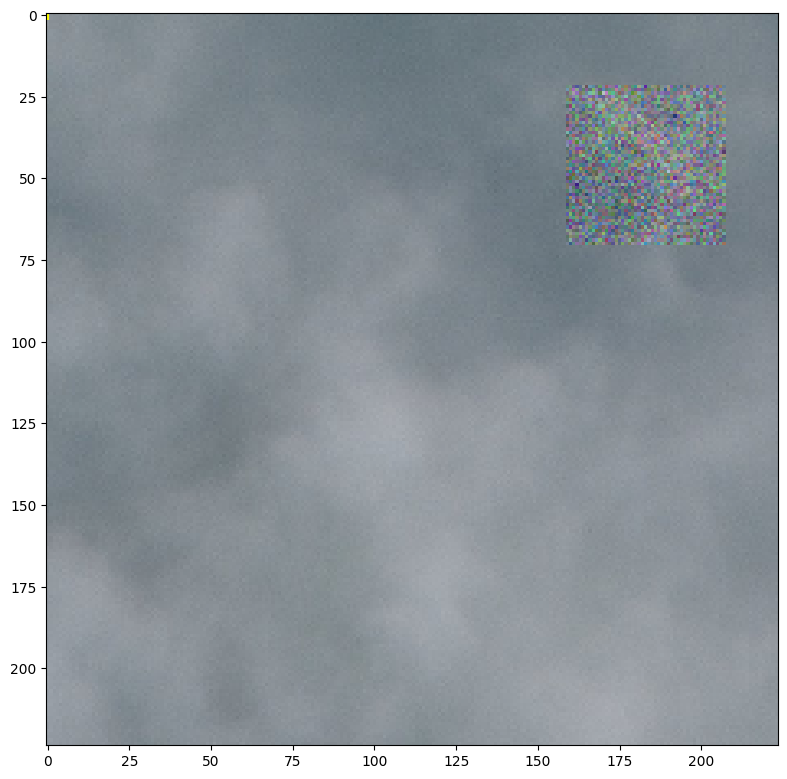

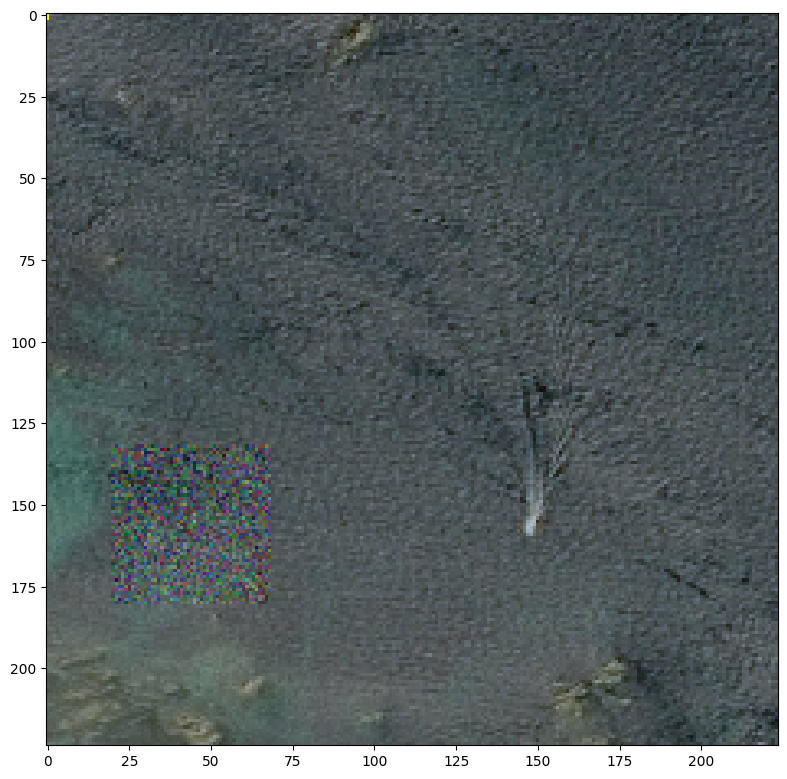

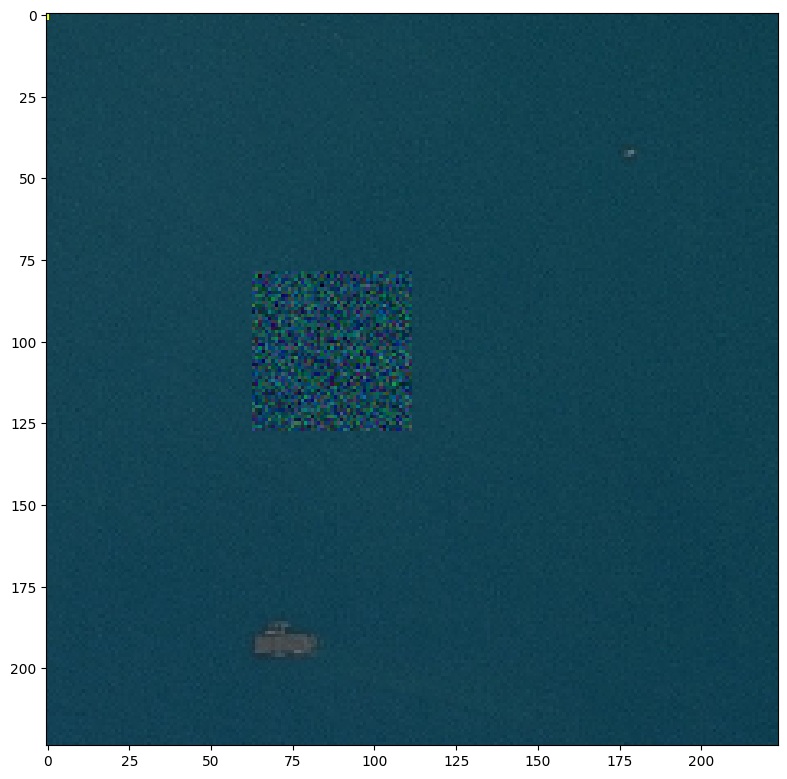

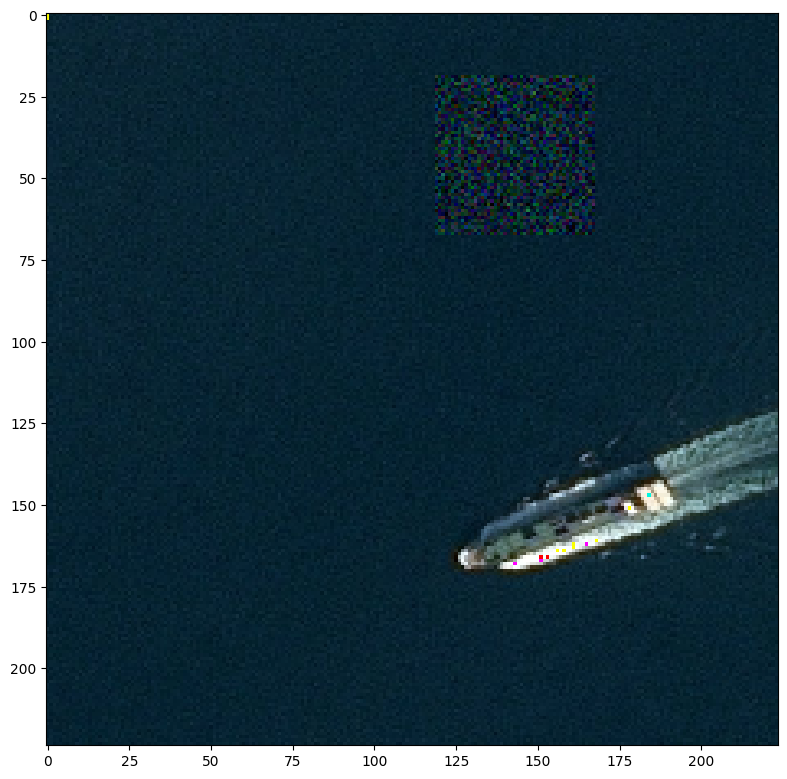

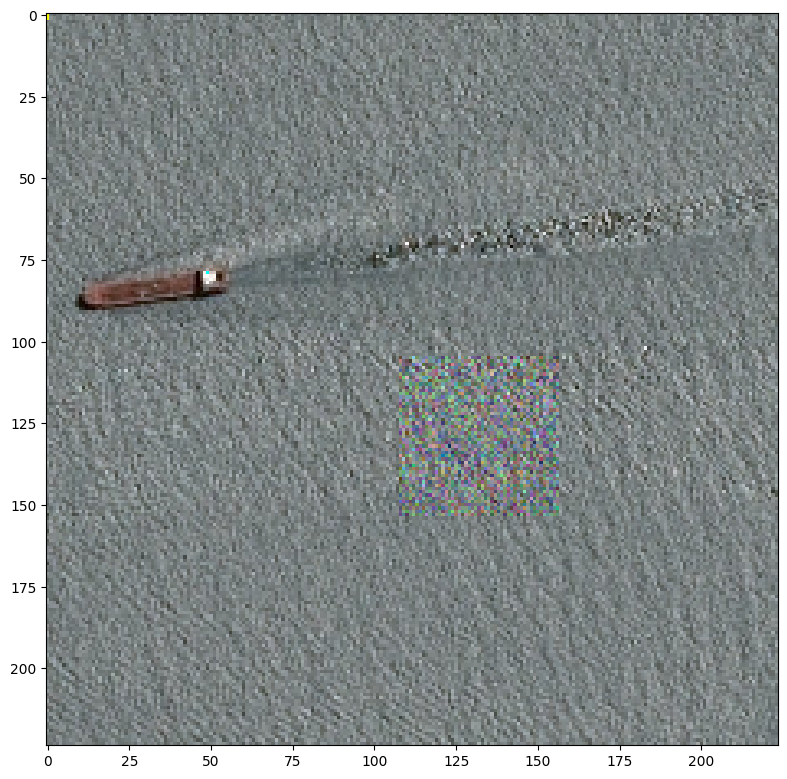

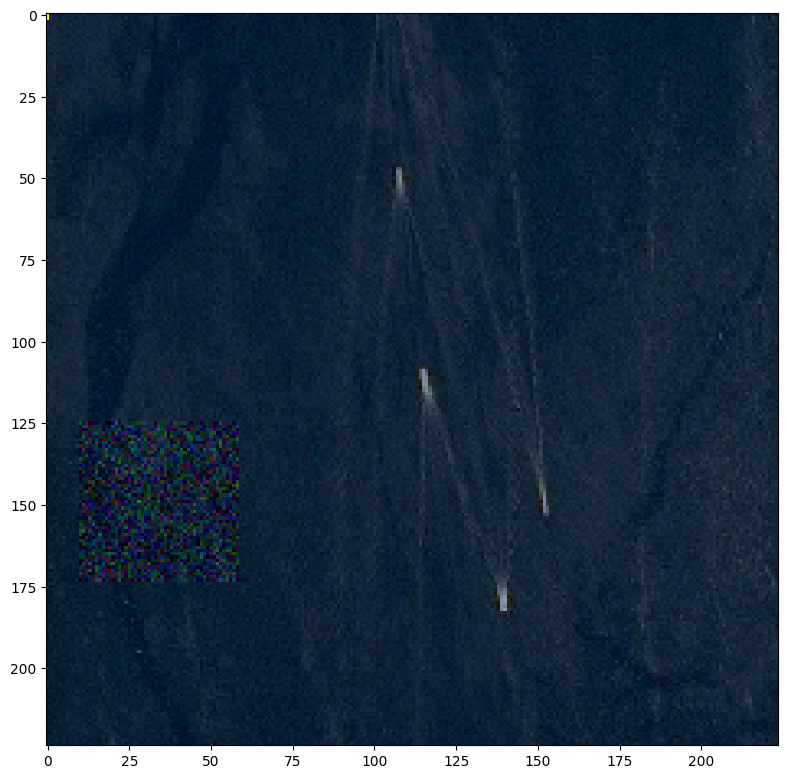

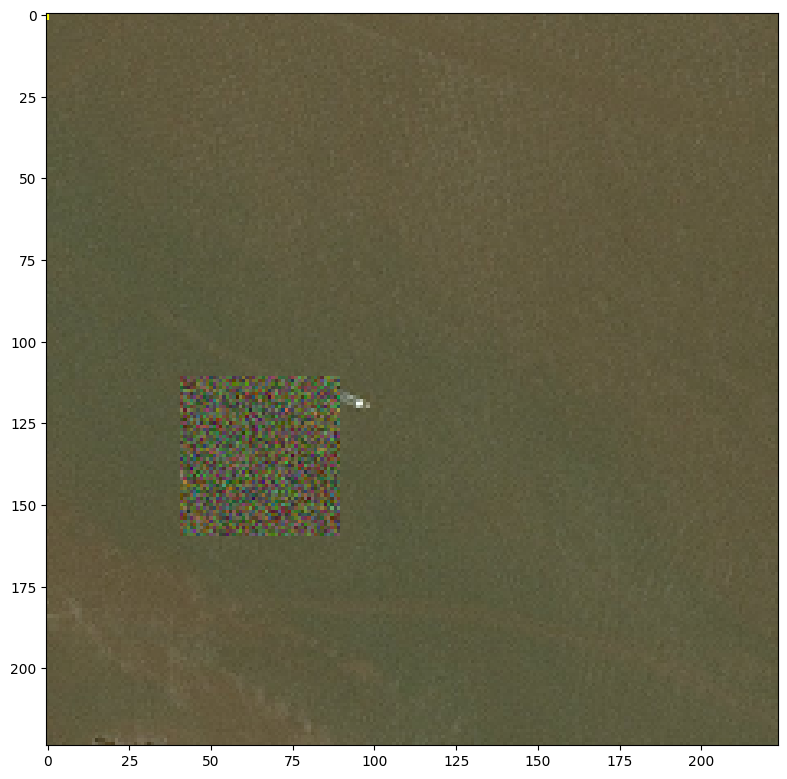

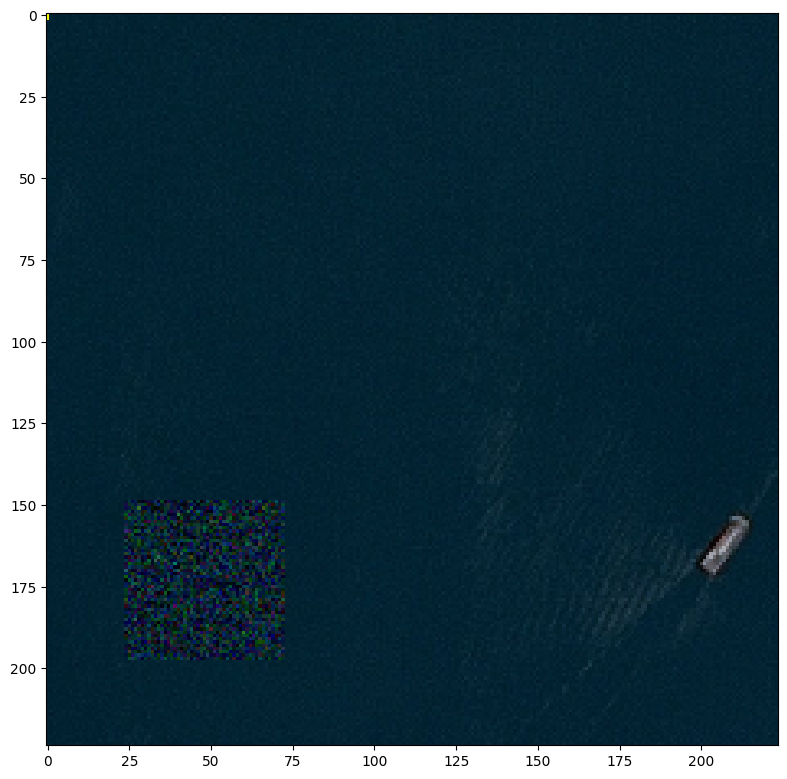

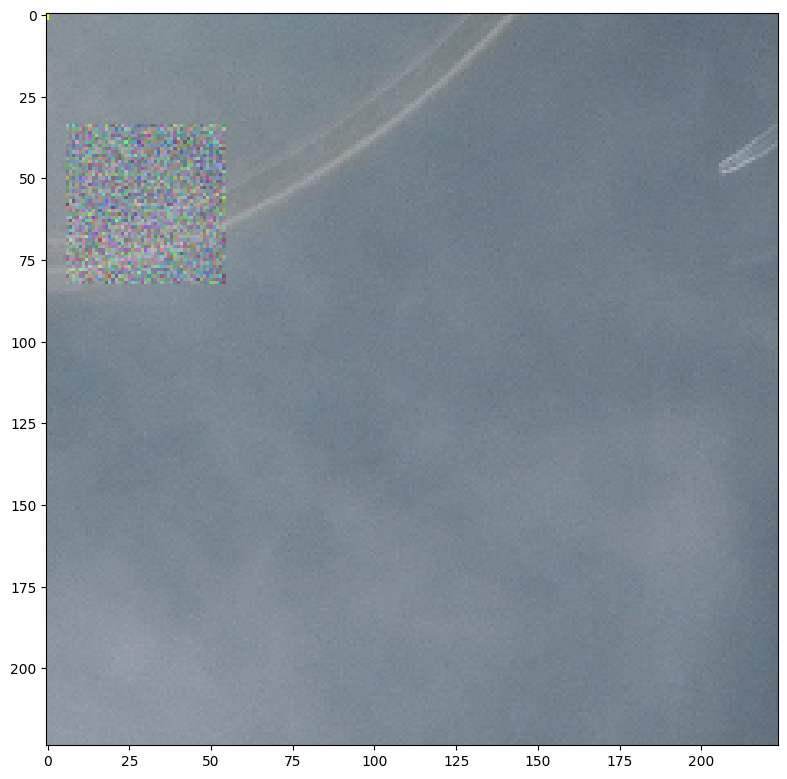

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.66 GiB. GPU 0 has a total capacty of 15.89 GiB of which 1.81 GiB is free. Process 4503 has 14.08 GiB memory in use. Of the allocated memory 6.11 GiB is allocated by PyTorch, and 7.68 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [109]:
#### START MODEL TRAINING

if not test_only:
    
    model = new_model()
    model.to(device)
    torch.compile(model)
    optimizer = optim.Adam(params = model.parameters(), lr = init_lr, weight_decay=0.01)

    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        gamma = 0.9,
        step_size = 5,
    )
    
    criterion = nn.CrossEntropyLoss()
    
    logger.info(f"Beginning training, {num_epochs = }, {device = }, {data_augmentation_type = }, {batch_size = }")
    print(f"Beginning training, {num_epochs = }, {data_augmentation_type = }, {batch_size = }")
    print(f"{device = }")
    
    train(model, optimizer, scheduler, criterion, train_loader, val_loader, epochs=num_epochs, device=device)
    
    # plots
#     fig, ax = plt.subplots()
#     ax.plot(lrs)    
#     ax.set(xlabel='epoch', ylabel='learning rate value')
#     fig.savefig(os.path.join(model_filepath, "lrs.png"))
#     print(f"{lrs = }")
#     logger.info(f"{lrs = }")

In [ ]:
import torchvision.transforms.functional as F

def test(model, test_loader, device=torch.device("cpu")): 
    
    model.transform.image_mean  = image_mean_test
    model.transform.image_std = image_std_test
    model._skip_resize = True
    
    model.eval()
    num_correct = 0
    num_examples = 0
    test_loss = 0
    metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.75])
    mAP = 0
    
    for i,batch in tqdm(enumerate(test_loader)):
        
        inputs = []
        targets = []
        
        for el in batch:       # el = (image,dict)
            if el[0] != None and not el[1]['labels'].numel() :
                inputs.append(el[0].to(device))
                targets.append(el[1])
                
        if len(inputs) == 0:
            continue
        
        output = model(inputs)
        # print(type(model(torch.cuda.FloatTensor(inputs))))
#         print("out :\n", output)
#         print("target :\n",targets)
        #     # Example output
        #     {'boxes': tensor([[
        #       0.3801,  0.3060,  3.5638,  3.0348],
        #     [ 0.2037,  0.6570,  1.9538,  4.9389],
        #     [ 0.4993,  0.7045,  5.1531,  5.5368],
        #     [ 0.7172,  0.0860,  8.0819,  3.2724],
        #     [ 0.3548,  1.4842,  3.9183,  9.8673],
        #     [ 0.9226,  0.4096, 11.7943,  6.0310]], grad_fn=<StackBackward0>),
        #     labels': tensor([1, 1, 1, 1, 1, 1]), 'scores': tensor([0.9762, 0.9498, 0.9188, 0.8941, 0.3722, 0.2909],
        #     grad_fn=<IndexBackward0>)},
        
        """
        scores come from RoIHeads class:
        pred_scores = F.softmax(class_logits, -1)
        after deleting empy boxes, low scored boxes and applying non-max suppression
        """
        
        for dic in output:
            dic["boxes"] = dic["boxes"].to(device)
            dic["labels"] = dic["labels"].to(device)
            dic["scores"] = dic["scores"].to(device)
            
        res = metric(output,targets)
        mAP += res['map_75']
        #print(res)

        
    mAP /= len(test_loader)  
    print( 'Mean Average Precision: {:.4f}'.format(mAP))

print("ok")

In [ ]:
# START MODEL TEST

if do_model_test or test_only:
#     checkpoint = torch.load(os.path.join('/kaggle/input/model-trained', "model.tar")) # LUDO
    checkpoint = torch.load(os.path.join(model_filepath, "model.tar"), map_location=device) # ENF
    test_loader = torch.load(os.path.join(model_filepath, "test_loader.pt"), map_location=device)
    
    model = new_model()
    model.load_state_dict(checkpoint['model_state_dict'])

    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("model is now using cuda")

    test(model.to(device), test_loader, device)

# checkpoint = torch.load(os.path.join('/kaggle/input/model-trained', "model.tar")) # ludo
# #checkpoint = torch.load(os.path.join(model_filepath, "model.tar")) # enf
# model.load_state_dict(checkpoint['model_state_dict'])
# test(model.to(device), test_loader, device=device)


In [ ]:
tensor.Tensor# TRAIN AGAIN (Continue training)

import pickle

if train_again:    
    # Load loaders
    train_loader = torch.load(os.path.join(model_filepath, 'train_loader.pt'), map_location=device)
    val_loader = torch.load(os.path.join(model_filepath, 'val_loader.pt'), map_location=device)
    test_loader = torch.load(os.path.join(model_filepath, 'test_loader.pt'), map_location=device)
    print("Loadeders and model loaded succesfully") 
    
#     print(f"{device = }")
    
    model = new_model()
    
    # Load model from checkpoint
    checkpoint = torch.load(os.path.join(model_filepath, "model.tar"), map_location=device)
    
    criterion = nn.CrossEntropyLoss()
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    
    optimizer = optim.Adam(params = model.parameters(), weight_decay=0.01, lr = 1e-2)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        gamma = 0.9,
        step_size = 5,
    )
    
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    training_losses = checkpoint['training_losses']
    validation_losses = checkpoint['validation_losses']
    lrs = checkpoint['lrs']
    epoch = checkpoint['epoch']
    # Resume training from a specific epoch
    # optimizer = optim.Adam(params = model.parameters(), lr=0.01)
    
    # Il file salvato model.tar contiene optiimzer, scheduler, loss e tanto altro

    logger.info(f"Continuing training, {num_epochs = }, {device = }, {data_augmentation_type = }, {batch_size = }")
    train(model, optimizer, scheduler, torch.nn.CrossEntropyLoss(), train_loader, val_loader, epochs=num_epochs, device=device)